In [20]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

### LightGBM

In [21]:
df_train = pd.read_csv('../data/train_con_features_encoded.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('../data/test_con_features_encoded.csv', index_col='Unnamed: 0')
display(df_train.head())

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,hermoso_titulo,cantidad_palabras_descripcion,relacion_palabras_descripcion,es_ciudad_capital,ciudad_turistica_top15,anio,mes,tipodepropiedad_cb,ciudad_cb,provincia_cb
0,254099,8.116114,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,...,0,0,0.000000,0,0,2015,8,2.763765e+06,3.384582e+06,3.471689e+06
1,53461,10.000000,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,...,0,1,0.007968,0,0,2013,6,2.898908e+06,4.604780e+06,3.471689e+06
2,247984,5.000000,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,...,0,10,0.046957,0,0,2015,10,2.398159e+06,8.890818e+05,2.367701e+06
3,209067,1.000000,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,...,0,0,0.000000,0,0,2012,3,2.398159e+06,1.479134e+06,2.762459e+06
4,185997,10.000000,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,...,0,1,0.074108,0,0,2016,6,2.763765e+06,2.749654e+06,2.367701e+06


In [22]:
#Guardo y remuevo la columna id de los datos
id_col = df_test['id']
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

#Separo features de entrenamiento del precio
feature_cols = df_train.columns.tolist()
feature_cols.remove('precio')

X = df_train[feature_cols]
y = df_train['precio']

feature_cols

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'precio_prom_idzona',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 39) (180000,)
(60000, 39) (60000,)


In [24]:
import lightgbm as lgb
from sklearn import metrics

#Se hizo una pasada para detectar ajustar hiperparametros y se mejoró manualmente
'''clf = lgb.LGBMRegressor()

gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'min_data_in_leaf':[10],
    'metric':['mae']
    }

grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(X_train,y_train)

grid.best_params_'''

"clf = lgb.LGBMRegressor()\n\ngridParams = {\n    'learning_rate': [0.05],\n    'num_leaves': [90,200],\n    'boosting_type' : ['gbdt'],\n    'objective' : ['regression'],\n    'max_depth' : [5,6,7,8],\n    'random_state' : [501], \n    'colsample_bytree' : [0.5,0.7],\n    'min_data_in_leaf':[10],\n    'metric':['mae']\n    }\n\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)\ngrid.fit(X_train,y_train)\n\ngrid.best_params_"

In [25]:
best_params = {
    'learning_rate': 0.04,      #best=0.04   
    'num_leaves': 512,          #best=512    MAE=482907 CATBOOST ENCODED ---> k=40
    'max_depth' : 12,           #best=12     MAE=XXXXXX  CATBOOST(ciudades) + ONE HOT ENCODED ---> k=70
    'objective' : 'regression', #            
    'random_state' : 501,       #best=501   
    'colsample_bytree' : 0.5,   #best=0.5   
    'min_data_in_leaf':10,      #best=10
    'metric':['mae']
    }

In [26]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

LightGBM = lgb.train(best_params, lgb_train, num_boost_round=1500, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's l1: 1.57142e+06
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 1.52216e+06
[3]	valid_0's l1: 1.4759e+06
[4]	valid_0's l1: 1.43338e+06
[5]	valid_0's l1: 1.39506e+06
[6]	valid_0's l1: 1.35838e+06
[7]	valid_0's l1: 1.31987e+06
[8]	valid_0's l1: 1.28648e+06
[9]	valid_0's l1: 1.25096e+06
[10]	valid_0's l1: 1.21711e+06
[11]	valid_0's l1: 1.18431e+06
[12]	valid_0's l1: 1.15267e+06
[13]	valid_0's l1: 1.12427e+06
[14]	valid_0's l1: 1.09508e+06
[15]	valid_0's l1: 1.0695e+06
[16]	valid_0's l1: 1.04358e+06
[17]	valid_0's l1: 1.01995e+06
[18]	valid_0's l1: 996398
[19]	valid_0's l1: 978863
[20]	valid_0's l1: 956880
[21]	valid_0's l1: 935831
[22]	valid_0's l1: 919046
[23]	valid_0's l1: 902339
[24]	valid_0's l1: 884507
[25]	valid_0's l1: 868500
[26]	valid_0's l1: 851957
[27]	valid_0's l1: 839445
[28]	valid_0's l1: 826371
[29]	valid_0's l1: 811607
[30]	valid_0's l1: 798342
[31]	valid_0's l1: 785864
[32]	valid_0's l1: 773950
[33]	valid_0's l1: 762378
[34]	va

[304]	valid_0's l1: 500584
[305]	valid_0's l1: 500528
[306]	valid_0's l1: 500509
[307]	valid_0's l1: 500437
[308]	valid_0's l1: 500324
[309]	valid_0's l1: 500260
[310]	valid_0's l1: 500241
[311]	valid_0's l1: 500178
[312]	valid_0's l1: 500179
[313]	valid_0's l1: 500150
[314]	valid_0's l1: 500082
[315]	valid_0's l1: 500077
[316]	valid_0's l1: 499989
[317]	valid_0's l1: 499937
[318]	valid_0's l1: 499844
[319]	valid_0's l1: 499806
[320]	valid_0's l1: 499711
[321]	valid_0's l1: 499632
[322]	valid_0's l1: 499569
[323]	valid_0's l1: 499519
[324]	valid_0's l1: 499486
[325]	valid_0's l1: 499446
[326]	valid_0's l1: 499359
[327]	valid_0's l1: 499282
[328]	valid_0's l1: 499218
[329]	valid_0's l1: 499173
[330]	valid_0's l1: 499133
[331]	valid_0's l1: 499058
[332]	valid_0's l1: 498966
[333]	valid_0's l1: 498945
[334]	valid_0's l1: 498899
[335]	valid_0's l1: 498860
[336]	valid_0's l1: 498830
[337]	valid_0's l1: 498764
[338]	valid_0's l1: 498665
[339]	valid_0's l1: 498612
[340]	valid_0's l1: 498535
[

[610]	valid_0's l1: 490287
[611]	valid_0's l1: 490277
[612]	valid_0's l1: 490256
[613]	valid_0's l1: 490236
[614]	valid_0's l1: 490230
[615]	valid_0's l1: 490233
[616]	valid_0's l1: 490217
[617]	valid_0's l1: 490173
[618]	valid_0's l1: 490161
[619]	valid_0's l1: 490156
[620]	valid_0's l1: 490126
[621]	valid_0's l1: 490089
[622]	valid_0's l1: 490085
[623]	valid_0's l1: 490071
[624]	valid_0's l1: 490031
[625]	valid_0's l1: 490041
[626]	valid_0's l1: 490052
[627]	valid_0's l1: 490043
[628]	valid_0's l1: 490024
[629]	valid_0's l1: 490008
[630]	valid_0's l1: 489993
[631]	valid_0's l1: 489987
[632]	valid_0's l1: 489971
[633]	valid_0's l1: 489960
[634]	valid_0's l1: 489941
[635]	valid_0's l1: 489935
[636]	valid_0's l1: 489939
[637]	valid_0's l1: 489939
[638]	valid_0's l1: 489920
[639]	valid_0's l1: 489884
[640]	valid_0's l1: 489887
[641]	valid_0's l1: 489890
[642]	valid_0's l1: 489867
[643]	valid_0's l1: 489825
[644]	valid_0's l1: 489816
[645]	valid_0's l1: 489807
[646]	valid_0's l1: 489789
[

[919]	valid_0's l1: 486342
[920]	valid_0's l1: 486331
[921]	valid_0's l1: 486319
[922]	valid_0's l1: 486311
[923]	valid_0's l1: 486301
[924]	valid_0's l1: 486280
[925]	valid_0's l1: 486268
[926]	valid_0's l1: 486261
[927]	valid_0's l1: 486253
[928]	valid_0's l1: 486243
[929]	valid_0's l1: 486241
[930]	valid_0's l1: 486229
[931]	valid_0's l1: 486217
[932]	valid_0's l1: 486206
[933]	valid_0's l1: 486201
[934]	valid_0's l1: 486197
[935]	valid_0's l1: 486186
[936]	valid_0's l1: 486173
[937]	valid_0's l1: 486172
[938]	valid_0's l1: 486167
[939]	valid_0's l1: 486152
[940]	valid_0's l1: 486153
[941]	valid_0's l1: 486136
[942]	valid_0's l1: 486133
[943]	valid_0's l1: 486119
[944]	valid_0's l1: 486096
[945]	valid_0's l1: 486098
[946]	valid_0's l1: 486088
[947]	valid_0's l1: 486079
[948]	valid_0's l1: 486078
[949]	valid_0's l1: 486078
[950]	valid_0's l1: 486074
[951]	valid_0's l1: 486050
[952]	valid_0's l1: 486026
[953]	valid_0's l1: 486023
[954]	valid_0's l1: 486008
[955]	valid_0's l1: 485991
[

[1217]	valid_0's l1: 484324
[1218]	valid_0's l1: 484324
[1219]	valid_0's l1: 484322
[1220]	valid_0's l1: 484322
[1221]	valid_0's l1: 484304
[1222]	valid_0's l1: 484287
[1223]	valid_0's l1: 484271
[1224]	valid_0's l1: 484262
[1225]	valid_0's l1: 484253
[1226]	valid_0's l1: 484249
[1227]	valid_0's l1: 484221
[1228]	valid_0's l1: 484213
[1229]	valid_0's l1: 484208
[1230]	valid_0's l1: 484197
[1231]	valid_0's l1: 484176
[1232]	valid_0's l1: 484148
[1233]	valid_0's l1: 484139
[1234]	valid_0's l1: 484124
[1235]	valid_0's l1: 484113
[1236]	valid_0's l1: 484110
[1237]	valid_0's l1: 484112
[1238]	valid_0's l1: 484112
[1239]	valid_0's l1: 484116
[1240]	valid_0's l1: 484112
[1241]	valid_0's l1: 484112
[1242]	valid_0's l1: 484084
[1243]	valid_0's l1: 484072
[1244]	valid_0's l1: 484065
[1245]	valid_0's l1: 484062
[1246]	valid_0's l1: 484057
[1247]	valid_0's l1: 484042
[1248]	valid_0's l1: 484035
[1249]	valid_0's l1: 484040
[1250]	valid_0's l1: 484032
[1251]	valid_0's l1: 484026
[1252]	valid_0's l1:

In [27]:
LightGBM_pred = LightGBM.predict(X_test, num_iteration=LightGBM.best_iteration)

In [28]:
from sklearn.metrics import mean_absolute_error

LightGBM_mae = mean_absolute_error(y_test, LightGBM_pred)
LightGBM_mae_train = mean_absolute_error(y_train, LightGBM.predict(X_train, num_iteration=LightGBM.best_iteration))
print(f"LightGBM (train): {LightGBM_mae_train:.5f}")
print(f"LightGBM: {LightGBM_mae:.5f}")
print("------------------------------")

LightGBM (train): 216883.31152
LightGBM: 482907.07011
------------------------------


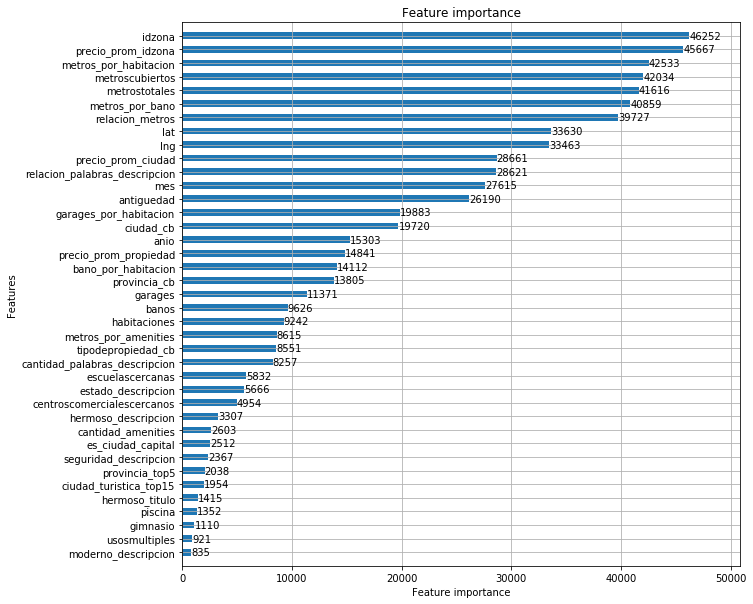

In [29]:
ax = lgb.plot_importance(LightGBM, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

In [30]:
LightGBM_pred_submit = LightGBM.predict(df_test, num_iteration=LightGBM.best_iteration)

In [31]:
resultado_submit = pd.DataFrame(index=df_test.index)
resultado_submit['id'] = id_col
resultado_submit['target'] = LightGBM_pred_submit
display(resultado_submit.head())
resultado_submit.to_csv('../data/submitLightGBM.csv',index=False)

,id,target
0,4941,8.060010e+06
1,51775,1.142078e+06
2,115253,2.387622e+06
3,299321,1.075801e+06
4,173570,6.429379e+05


#### Score en Kaggle (features => score):
 **1.** ***Usando CatBoost encoded*** y ['id',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***573846.94092*** con 'learning_rate': 0.03,
    'num_leaves': 256,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.7,
    'subsample' : 0.7,
    'min_split_gain' : 0.01,
    'min_data_in_leaf':10,
***LOCAL MAE: 568518.75474***

 **2.** ***Usando CatBoost encoded y k=30*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***532012.21935*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 522286.09996***

 **3.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***530839.77082*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 521747.30395***

 **4.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad' (si value_count > 10),
 'precio_prom_propiedad',
 'precio_prom_idzona' (si value_count >=5),
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***503282.81680*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 489179.65249***

 **5.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad' (si value_count > 10),
 'precio_prom_propiedad',
 'precio_prom_idzona' (si value_count >=2),
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***501835.72387*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 482907***